In [1]:
import os
import pickle
from typing import Callable

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

from utils.core import(
    bound_critical_parameter,
    locate_critical_parameter,
    bruteforce_parameter_and_energy_relationship,
)

from utils.plot import draw_horizons, blend_color
from utils.utilities import geospace
import utils.plot as plot_utils

In [ ]:
### SPECIFY PARAMETERS

# Runge-Kutta parameters
R_MIN = 1.0
R_MAX = 1000.0
STEP = -0.05

# secant method parameters
SECANT_TOLERANCE = 1e-8
SECANT_MAX_ITERS = 50
SECANT_INITIAL_STEP = 1e-6


# critical parameter in the parameter space

MAX_ITERS = 20
ALPHA_MAX = 500 # ad hoc, could be arbirtrarily large
ALPHA_MIN = 0

# locate critical parameter value using binary search

BISECTION_TOLERANCE = 1e-11
BISECTION_MAX_ITERS = 20
BISECTION_ROOT_TOLERANCE = 1e-3

# brutefore parameter range setup
COUNT = 100
OFFSET = 50
RATIO = 0.9

# Density profile

RADIUS = 500
INNER_RADIUS = 0.05 * RADIUS
WIDTH = 10

shell = "two_constant"

def get_rho(parameter: float) -> Callable[[float], float]:

    amplitude = parameter
    radius = RADIUS
    inner_radius = INNER_RADIUS
    center_radius = 250
    width = 10 / 2

    @njit
    def _rho(x: float) -> float:
        if (radius - width < x < radius + width):
                return amplitude
        elif (inner_radius - width < x < inner_radius + width):
                return 1e-8
        else:
                return 0.0
    return _rho

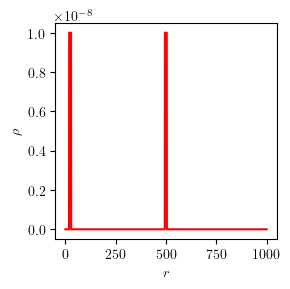

In [3]:
# plot the density profile

unit_rho = get_rho(1e-8)
r_vals = np.arange(R_MAX, R_MIN + STEP, STEP)
unit_rho_vals = [unit_rho(_r) for _r in r_vals]\

plt.figure(figsize=(3, 3))
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.plot(r_vals, unit_rho_vals, color="red")
plt.tight_layout()
plt.show()

In [4]:
forced = False # if True, the code will always run the brute-force search and save results to a file

if not forced and (os.path.isfile("data/" +  shell + "_critical.pkl")):
    with open("data/" +  shell + "_critical.pkl", "rb") as f:
        results = pickle.load(f)

    critical_alpha = results["critical_alpha"]
    critical_parameter = results["critical_parameter"]

else:
    ((parameter_lower, parameter_upper), (alpha_lower, alpha_upper), boolean_success) = bound_critical_parameter(
        _get_rho = get_rho,
        rk_start = R_MAX,
        rk_end = R_MIN,
        rk_step = STEP,
        secant_tolerance = SECANT_TOLERANCE,
        secant_max_iters = SECANT_MAX_ITERS,
        secant_initial_step = SECANT_INITIAL_STEP,
        parameter_max = None,
        alpha_max = ALPHA_MAX,
        alpha_min = ALPHA_MIN,
        max_iters = MAX_ITERS,
        minimal_seeked_bound_distance = 1e-3,
        verbose = True,
        scale = 1.5,
    )

    critical_alpha, critical_parameter, _ = locate_critical_parameter(
        _get_rho = get_rho,
        start = parameter_lower,
        end = parameter_upper,
        alpha_start = alpha_lower,
        alpha_end = alpha_upper,
        rk_start = R_MAX,
        rk_end = R_MIN,
        rk_step = STEP,
        secant_tolerance = SECANT_TOLERANCE,
        secant_max_iters = SECANT_MAX_ITERS,
        secant_initial_step = SECANT_INITIAL_STEP,
        bisection_tolerance = BISECTION_TOLERANCE,
        bisection_max_iters = BISECTION_MAX_ITERS,
        bisection_root_tol = BISECTION_ROOT_TOLERANCE
    )

    with open("data/" +  shell + "_critical.pkl", "wb") as f:
        pickle.dump(
            {
                "critical_alpha": critical_alpha,
                "critical_parameter": critical_parameter,
            },
            f,
    )
    

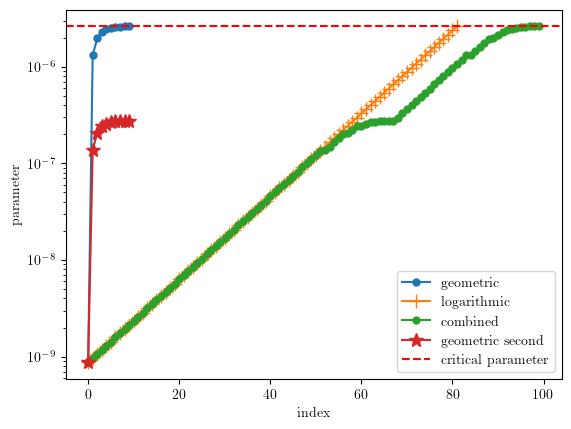

In [6]:
# sample parameters for the brute-force search

offset = 3000
ratio = 0.5

geometric_count = 10
geometric_second_count = 10
logarithmic_count = 82

geometric = geospace(critical_parameter / offset, critical_parameter, steps = geometric_count, ratio=ratio)
geometric_second = geospace(critical_parameter / offset, 2.75e-7, steps = geometric_second_count, ratio=ratio)
logarithmic = np.logspace(np.log10(critical_parameter / offset), np.log10(critical_parameter), logarithmic_count, base=10.0)
parameters = np.concatenate((geometric, logarithmic, geometric_second))
parameters = np.sort(parameters)
parameters = parameters[2:]  # first value is duplicit


# smooth out the parameters using a rolling mean, but keep the endpoints fixed!

plt.plot(range(len(geometric)), geometric, label="geometric", marker=".", markersize=10)
plt.plot(range(len(logarithmic)), logarithmic, label="logarithmic", marker="+", markersize=10)
plt.plot(range(len(parameters)), parameters, label="combined", marker=".", markersize=10)
plt.plot(range(len(geometric_second)), geometric_second, label="geometric second", marker="*", markersize=10)

plt.axhline(y=critical_parameter, color="r", linestyle="--", label="critical parameter")
plt.yscale("log")
plt.xlabel("index")
plt.ylabel("parameter")
plt.legend()
plt.show()

# ∇ Ψ + 2πρ Ψ^exponent = 0
exponent = 5 # for scaling
parameter_search_range = parameters.copy()
alpha_search_range = np.linspace(0, 10000, 60) # starting guesses, ad hoc, could be arbirtrarily large

In [7]:
forced = False

if not forced and (os.path.isfile("data/" +  shell + "_results.pkl")):
    with open("data/" +  shell + "_results.pkl", "rb") as f:
        results = pickle.load(f)

    ADM_mass_vals = results["E_ADM"]
    rest_mass_vals = results["rest_mass"]
    parameters = results["parameters"]
    horizons = results["horizons"]

else:

    ADM_mass_vals, rest_mass_vals, parameters, horizons = bruteforce_parameter_and_energy_relationship(
        get_rho,
        parameter_search_range,
        alpha_search_range,
        (R_MAX, R_MIN, STEP),
        (SECANT_TOLERANCE, SECANT_MAX_ITERS, SECANT_INITIAL_STEP),
        exponent = exponent,
        unique_root_tolerance=1e-4,
    )

    with open("data/" +  shell + "_results.pkl", "wb") as f:
        pickle.dump(
            {
                "E_ADM": ADM_mass_vals,
                "rest_mass": rest_mass_vals,
                "parameters": parameters,
                "horizons": horizons,
            },
            f,
        )

In [20]:
critical_parameter

2.6184048936320717e-06

In [8]:
horizon_parameters = [val[0] for val in horizons]
horizon_ADM_mass = [val[1] for val in horizons]
horizon_rest_mass = [val[2] for val in horizons]
horizon_radii = [val[3] for val in horizons]

numerical c. amplitude 2.6184048936320717e-06
numerical c. ADM mass: 250.84014761805935


[]

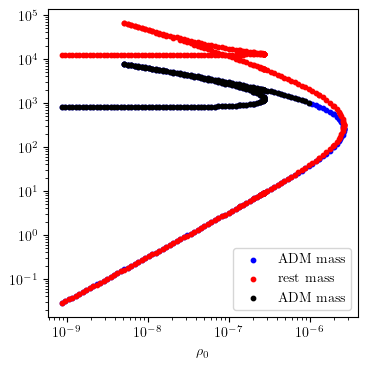

In [9]:
print(f"numerical c. amplitude {critical_parameter}")
print(f"numerical c. ADM mass: {2 * critical_alpha}")

plt.figure(figsize=(4, 4))



plt.scatter(
    parameters,
    ADM_mass_vals,
    label="ADM mass",
    color="blue",
    s=10
)

plt.scatter(
    parameters,
    rest_mass_vals,
    label="rest mass",
    color="red",
    s=10
)


plt.scatter(horizon_parameters, horizon_ADM_mass, label="ADM mass", color="black", s=10)

# plt.xlim(10**-9, 4*10**-6)
# plt.ylim(0.5*10**3, 10**5)

plt.xlabel(r"$\rho_0$")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.plot()

first horizon found at approx. parameter 9.7e-07 with ADM energy 1e+03 and rest mass 2e+03


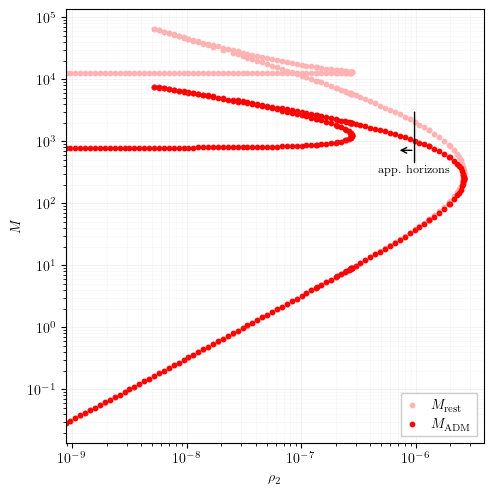

In [17]:
scale = 0.8
width = plot_utils.textwidth * scale * plot_utils.cm_to_inch
height = width

color = "red"
lighter_color = blend_color(color, 0.3)

fig = plt.figure(figsize=(width, height), tight_layout=True)

draw_horizons(horizons, exponent = exponent, delta=0.6, arrow_length=0.6)


plt.scatter(
    parameters,
    rest_mass_vals,
    label=r"$M_{\text{rest}}$",
    color=lighter_color,
    s=10
)

plt.scatter(
    parameters,
    ADM_mass_vals,
    label=r"$M_{\text{ADM}}$",
    color="red",
    s=10
)



# plt.xlim(10**-9, 4*10**-6)
# plt.ylim(0.5*10**3, 10**5)

plt.xlim(min(parameters), max(parameters)*1.5)

plt.xlabel(r"$\rho_2$")
plt.ylabel(r"$M$")


plt.minorticks_on()

plt.xscale("log")
plt.yscale("log")
plt.legend(
    loc="lower right",
    framealpha=1, frameon=True, ncol=1,
    handlelength=0.8, handletextpad=1, columnspacing=0.8, fancybox=False)



plt.grid(axis="both", linestyle="-", linewidth=0.5, alpha=0.2, which='major')
plt.grid(axis="both", linestyle="-", linewidth=0.5, alpha=0.1, which='minor')

plt.savefig("img/" + shell + "_sol_curves.pdf", dpi=300, bbox_inches='tight')
plt.show()

[]

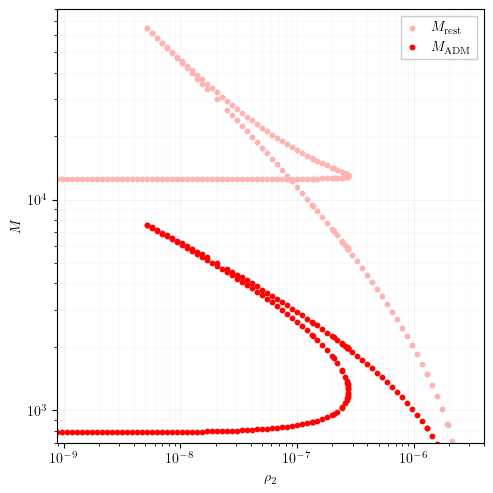

In [22]:
scale = 0.8
width = plot_utils.textwidth * scale * plot_utils.cm_to_inch
height = width

color = "red"
lighter_color = blend_color(color, 0.3)

fig = plt.figure(figsize=(width, height), tight_layout=True)



plt.scatter(
    parameters,
    rest_mass_vals,
    label=r"$M_{\text{rest}}$",
    color=lighter_color,
    s=10
)

plt.scatter(
    parameters,
    ADM_mass_vals,
    label=r"$M_{\text{ADM}}$",
    color="red",
    s=10
)

plt.xlim(10**-9, 4*10**-6)
plt.ylim(0.7*10**3, 0.8*10**5)

plt.xlim(min(parameters))

plt.xlabel(r"$\rho_2$")
plt.ylabel(r"$M$")


plt.minorticks_on()

plt.xscale("log")
plt.yscale("log")
plt.legend(
    loc="upper right",
    framealpha=1, frameon=True, ncol=1,
    handlelength=0.8, handletextpad=1, columnspacing=0.8, fancybox=False)

plt.grid(axis="both", linestyle="-", linewidth=0.5, alpha=0.2, which="major")
plt.grid(axis="both", linestyle="-", linewidth=0.5, alpha=0.1, which="minor")
plt.savefig("img/" + shell + "_sol_curves_zoom.pdf", dpi=300, bbox_inches="tight")


plt.plot()